For the project to work correctly the data should be held in /archive/ with filenames fraudTest.csv and fraudTrain.csv.
The dataset is: https://www.kaggle.com/datasets/kartik2112/fraud-detection

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from imblearn.over_sampling import SMOTE


In [2]:
train_df = pd.read_csv("archive/fraudTrain.csv")
test_df  = pd.read_csv("archive/fraudTest.csv")

print(train_df.shape, test_df.shape)


(1296675, 23) (555719, 23)


In [3]:
train_df['is_fraud'].value_counts(normalize=True)


is_fraud
0    0.994211
1    0.005789
Name: proportion, dtype: float64

In [4]:


cols_to_drop = [
    'Unnamed: 0', 'trans_date_trans_time',
    'cc_num', 'first', 'last',
    'street', 'city', 'state', 'zip',
    'lat', 'long', 'dob',
    'trans_num'
]

train_df.drop(columns=cols_to_drop, inplace=True, errors='ignore')
test_df.drop(columns=cols_to_drop, inplace=True, errors='ignore')

encoder = LabelEncoder()
train_df["merchant"] = encoder.fit_transform(train_df["merchant"])
train_df["category"] = encoder.fit_transform(train_df["category"])
train_df["gender"] = encoder.fit_transform(train_df["gender"])
train_df["job"] = encoder.fit_transform(train_df["job"])
test_df["merchant"] = encoder.fit_transform(test_df["merchant"])
test_df["category"] = encoder.fit_transform(test_df["category"])
test_df["gender"] = encoder.fit_transform(test_df["gender"])
test_df["job"] = encoder.fit_transform(test_df["job"])

In [5]:
X_train = train_df.drop('is_fraud', axis=1)
y_train = train_df['is_fraud']

X_test = test_df.drop('is_fraud', axis=1)
y_test = test_df['is_fraud']



In [6]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)


In [7]:
smote = SMOTE(random_state=42)

X_train_res, y_train_res = smote.fit_resample(
    X_train_scaled, y_train
)

print("Before SMOTE:")
print(y_train.value_counts())

print("\nAfter SMOTE:")
print(pd.Series(y_train_res).value_counts())


Before SMOTE:
is_fraud
0    1289169
1       7506
Name: count, dtype: int64

After SMOTE:
is_fraud
0    1289169
1    1289169
Name: count, dtype: int64


Logistic regression

In [8]:
lr = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    random_state=42
)

lr.fit(X_train_res, y_train_res)

y_pred_lr = lr.predict(X_test_scaled)
y_prob_lr = lr.predict_proba(X_test_scaled)[:, 1]

print("LOGISTIC REGRESSION")
print(classification_report(y_test, y_pred_lr))
print("ROC AUC:", roc_auc_score(y_test, y_prob_lr))


LOGISTIC REGRESSION
              precision    recall  f1-score   support

           0       1.00      0.97      0.98    553574
           1       0.08      0.74      0.15      2145

    accuracy                           0.97    555719
   macro avg       0.54      0.85      0.56    555719
weighted avg       1.00      0.97      0.98    555719

ROC AUC: 0.8482475205850941


Random forest

In [18]:
rf = RandomForestClassifier(
    n_estimators=50,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train_res, y_train_res)

y_pred_rf = rf.predict(X_test_scaled)
y_prob_rf = rf.predict_proba(X_test_scaled)[:, 1]

print("RANDOM FOREST")
print(classification_report(y_test, y_pred_rf))
print("ROC AUC:", roc_auc_score(y_test, y_prob_rf))


RANDOM FOREST
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.78      0.35      0.48      2145

    accuracy                           1.00    555719
   macro avg       0.89      0.67      0.74    555719
weighted avg       1.00      1.00      1.00    555719

ROC AUC: 0.964592546035858


SVC

In [11]:
base_svc = LinearSVC(
    class_weight='balanced',
    max_iter=5000
)

svc_calibrated = CalibratedClassifierCV(
    estimator=base_svc,
    method='sigmoid',  # Platt scaling
    cv=3
)

svc_calibrated.fit(X_train_res, y_train_res)

# Now this works
y_pred_svc = svc_calibrated.predict(X_test_scaled)
y_prob_svc = svc_calibrated.predict_proba(X_test_scaled)[:, 1]

print("SUPPORT VECTOR CLASSIFIER")
print(classification_report(y_test, y_pred_svc))
print("ROC AUC:", roc_auc_score(y_test, y_prob_svc))

SUPPORT VECTOR CLASSIFIER
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    553574
           1       0.12      0.72      0.21      2145

    accuracy                           0.98    555719
   macro avg       0.56      0.85      0.60    555719
weighted avg       1.00      0.98      0.99    555719

ROC AUC: 0.8522390535288539


Comparison

In [12]:
summary = pd.DataFrame({
    "Model": [
        "Logistic Regression",
        "Random Forest",
        "Support Vector Classifier"
    ],
    "ROC AUC": [
        roc_auc_score(y_test, y_prob_lr),
        roc_auc_score(y_test, y_prob_rf),
        roc_auc_score(y_test, y_prob_svc)
    ]
})

summary.sort_values(by="ROC AUC", ascending=False)


,Model,ROC AUC
1,Random Forest,0.892633
2,Support Vector Classifier,0.852239
0,Logistic Regression,0.848248


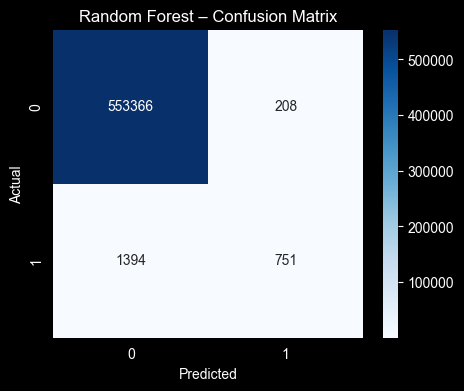

In [19]:
cm = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Random Forest – Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


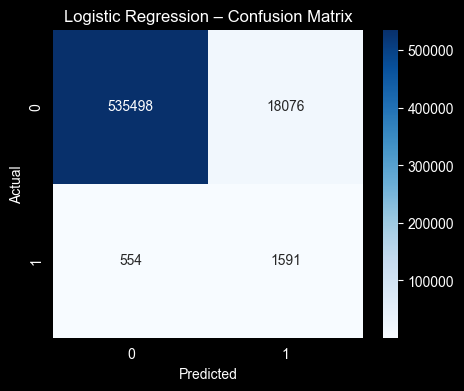

In [16]:

cm = confusion_matrix(y_test, y_pred_lr)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Logistic Regression – Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


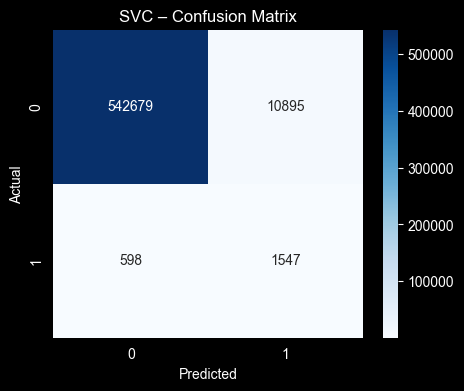

In [17]:
cm = confusion_matrix(y_test, y_pred_svc)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("SVC – Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
